# Decision Tree for churn prediction

Next we used a decision tree because they generally perform well on classification tasks. It's a white box model so easy to explain and can deal with categorical features; though this is not yet implemented in scikit-learn. In general, decision trees require only little feature engineering. A downside is that they tend to overfit quite easily, so regularization (pruning the tree) is important.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import os
from scipy.stats import chi2_contingency
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.model_selection import GridSearchCV
from myfunctions import prediction_matrices, save_metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
df_train = pd.read_pickle('./data/df_train_dt.pkl')
df_test = pd.read_pickle('./data/df_test_dt.pkl')

# Assign Target and Features

In [3]:
X_train = df_train.drop("churn_risk_score", axis = 1)
y_train = df_train["churn_risk_score"]

X_test = df_test.drop("churn_risk_score", axis = 1)
y_test = df_test["churn_risk_score"]

In [4]:
#X_train_train = X_train.astype(float)
y_train = y_train.astype(int)

y_test = y_test.astype(int)

In [5]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

## Prediction scores and matrices

Report on train set : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     12798
           1       1.00      1.00      1.00     14972

    accuracy                           1.00     27770
   macro avg       1.00      1.00      1.00     27770
weighted avg       1.00      1.00      1.00     27770

--------------------------------------------------------------------------------
Accuracy on test set: 0.91
ROC on test set: 0.91
Report on test set : 
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      3167
           1       0.92      0.91      0.91      3779

    accuracy                           0.91      6946
   macro avg       0.90      0.91      0.90      6946
weighted avg       0.91      0.91      0.91      6946



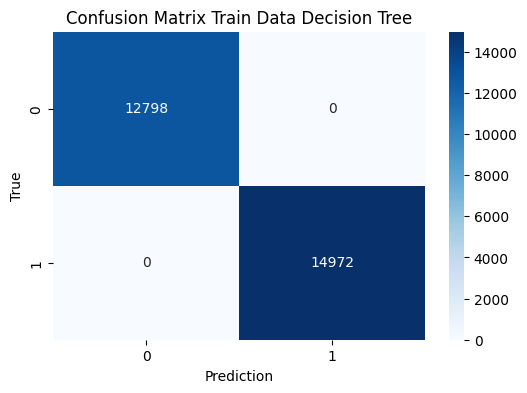

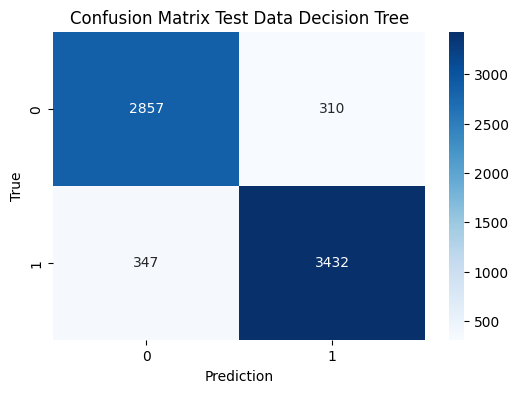

In [6]:
#plot predictio matrices
prediction_matrices(model = clf, X_train= X_train, X_test= X_test, y_train=y_train, y_test= y_test, model_name= "Decision Tree")

The comparison of the predictions based on train and test data suggest an overfitting that is typical for decison trees (when not pruned). The prediction on train data results in perfect scores, while the prediction on test data scored around 91%.

In [7]:
# Scores
print("Scores for decision tree")
print("________________________________")
print('F1-Score=%.3f' % (f1_score(y_test, y_pred)))
print('Precision=%.3f, Recall=%.3f, Accuracy = %.3f' % (precision_score(y_test, y_pred), recall_score(y_test, y_pred), accuracy_score(y_test, y_pred)))

Scores for decision tree
________________________________
F1-Score=0.913
Precision=0.917, Recall=0.908, Accuracy = 0.905


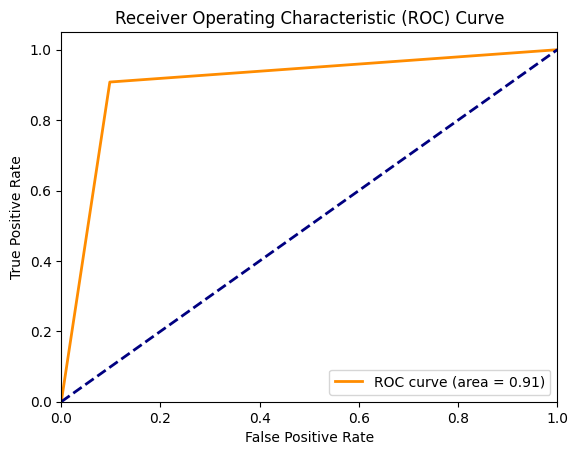

In [8]:
# ROC Curve
y_pred_roc = clf.predict_proba(X_test)[:, 1] # Probability of positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

## Visualize the decision tree

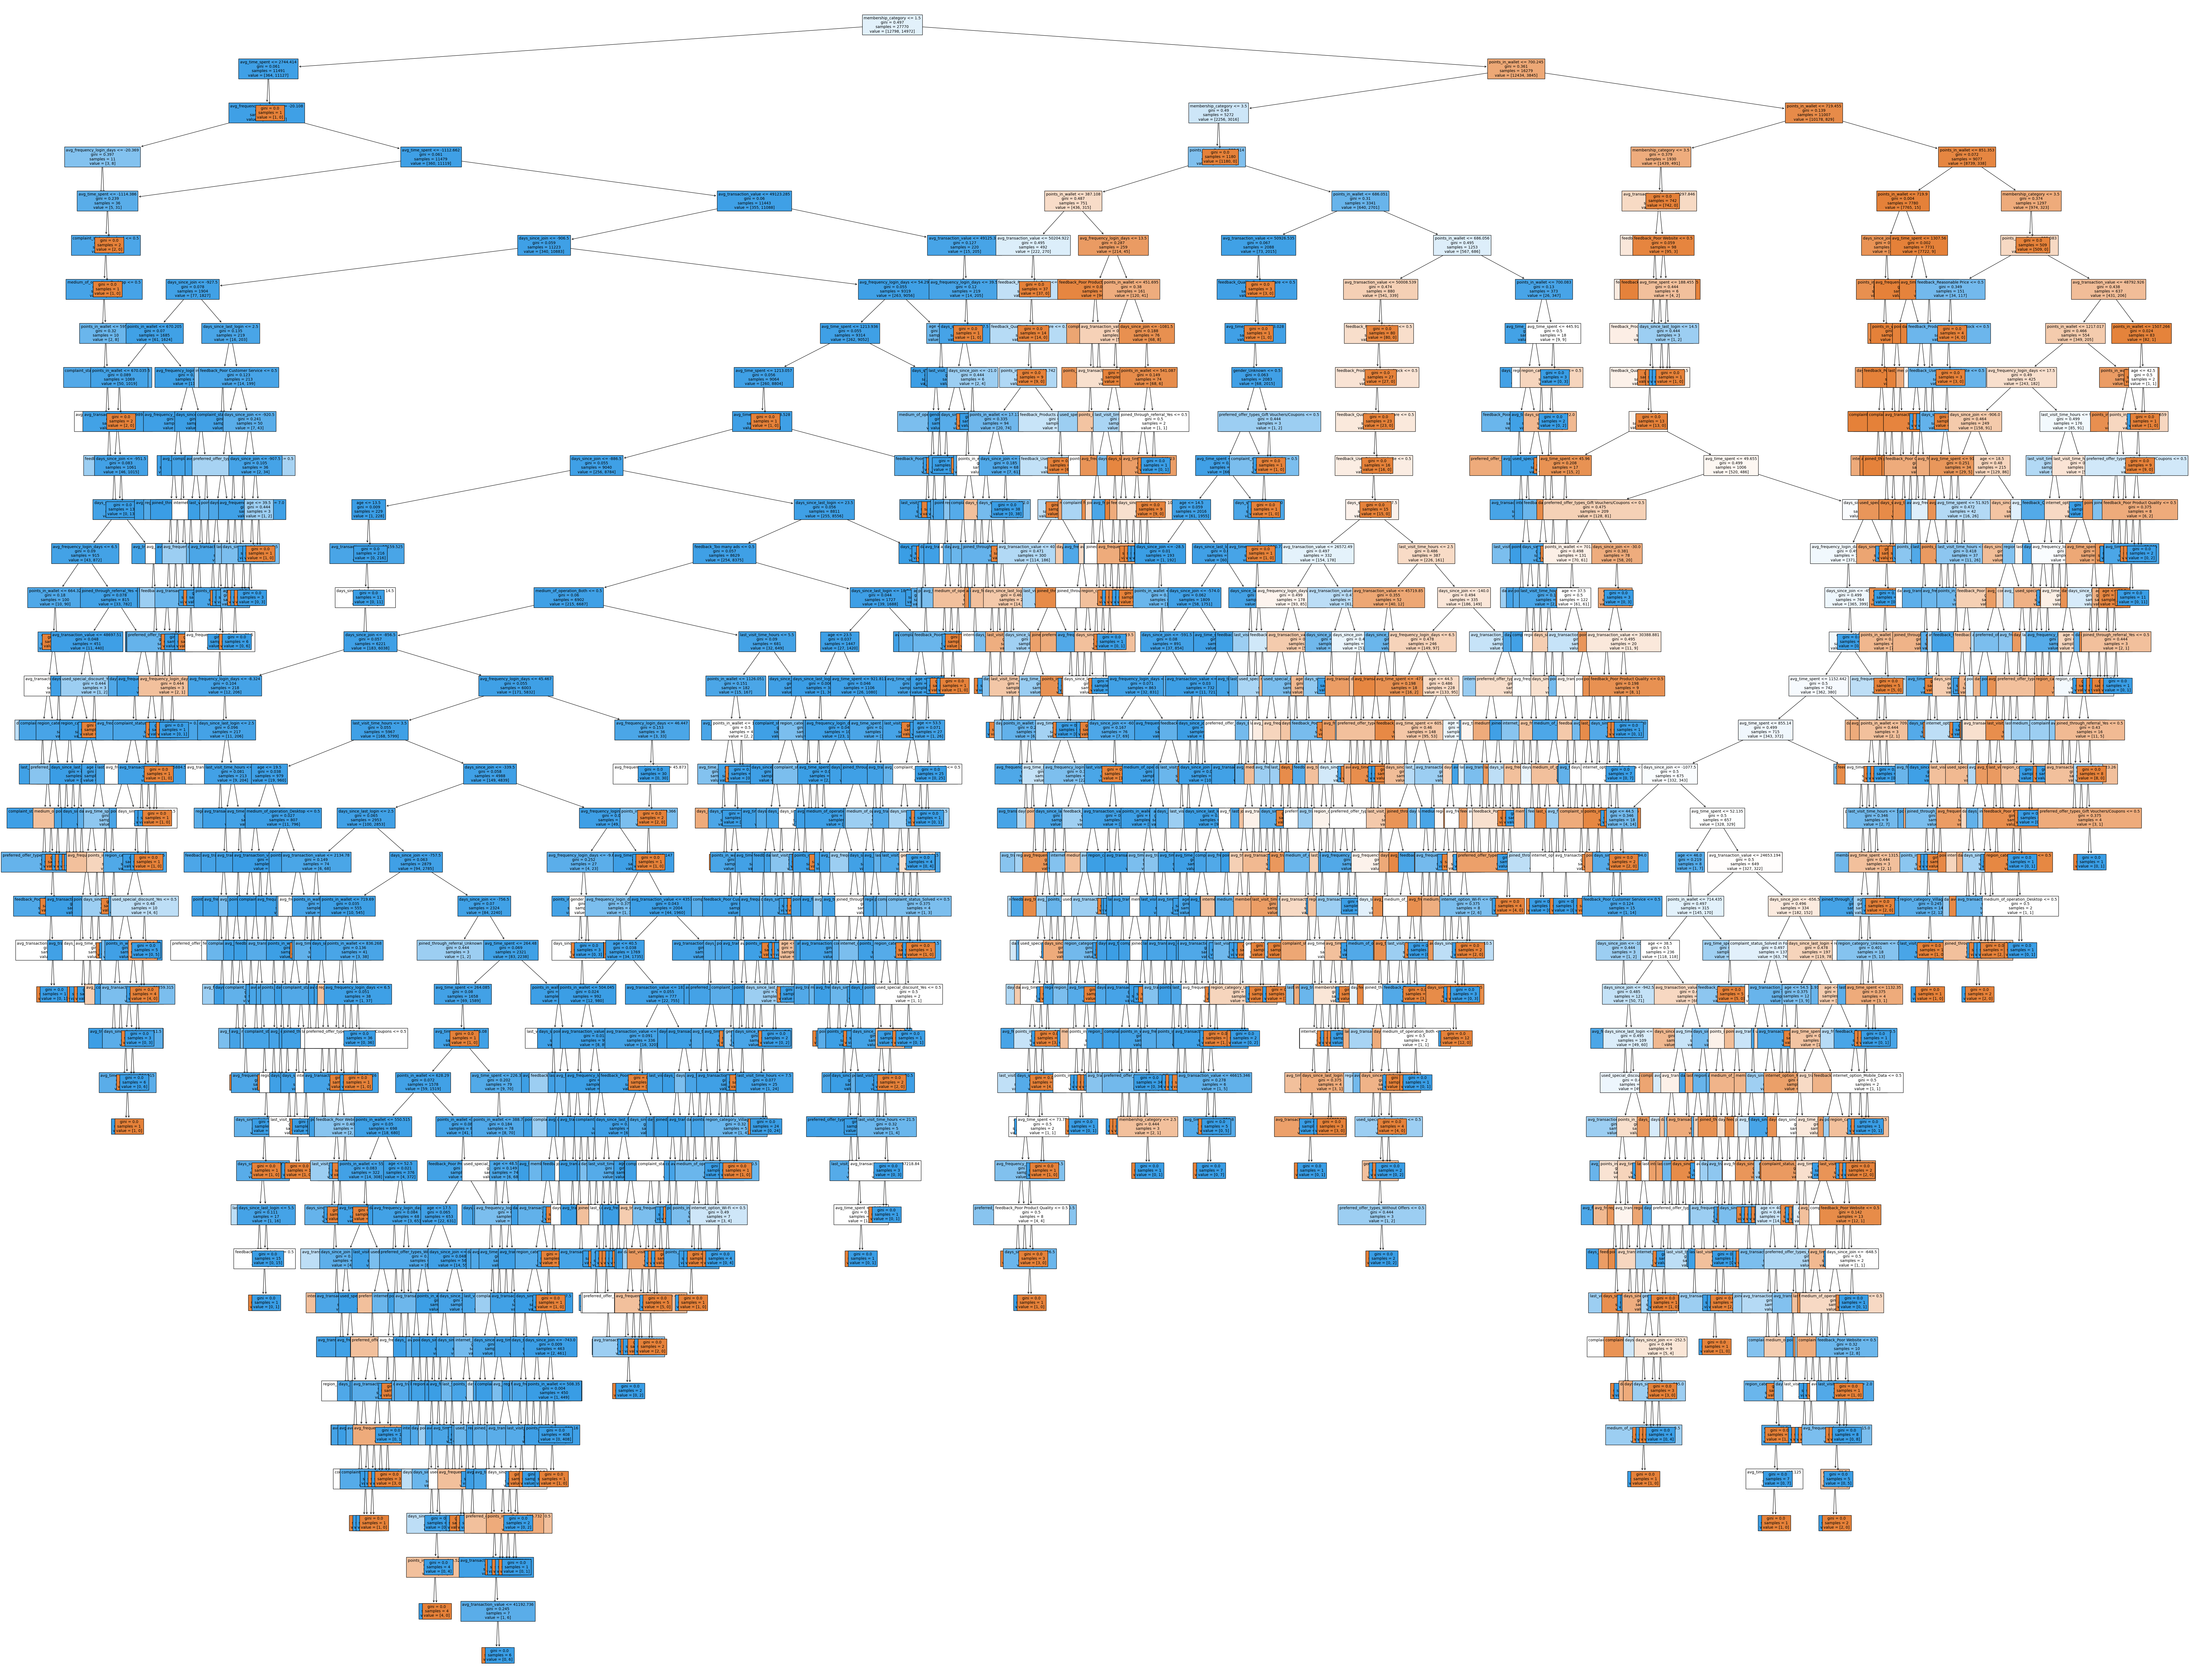

In [9]:
features = X_train.columns
fig = plt.figure(figsize=(100,80))
dectree_plot = plot_tree(clf,feature_names=features, filled=True,fontsize= 10)

The decision tree is very complex and shows a high number of nodes and leafs for prediction. This further underlines our assessment that this model is probably overfitted.

## Feature Importance

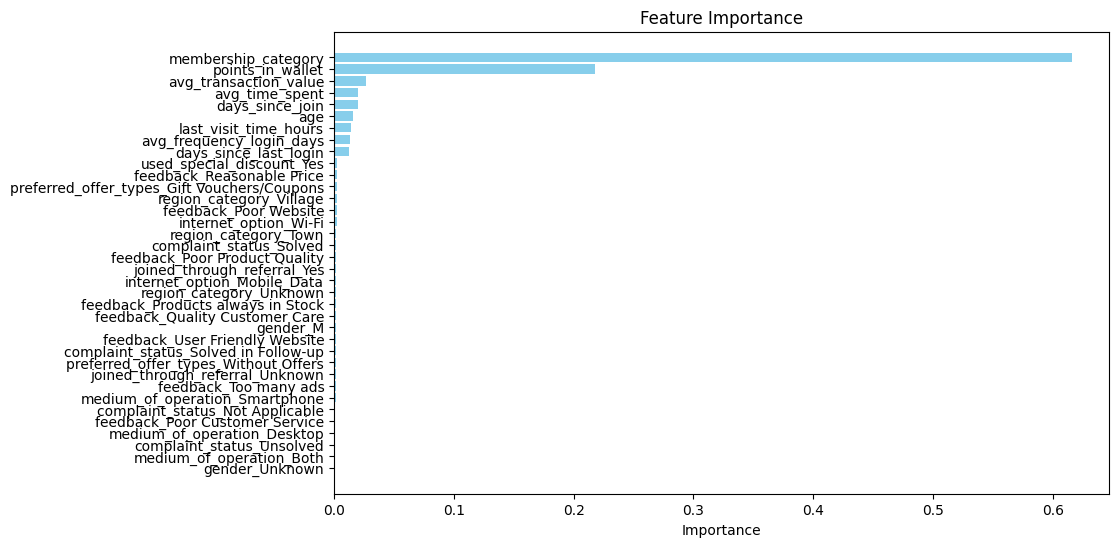

In [10]:
#feature importance
importances = clf.feature_importances_
features = X_train.columns


# create data frame for handling importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# sort by importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# create Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

The results are mainly based on two features: membership_category and points_in_wallet. Further features that play a medium role mainly indicate the historical and recent interaction of the customer with the platform (e.g., avg_time_spent). Interestingly, feedback does not play an important role for the prediction (contrary to our learnings from the EDA).

## Save Model

In [11]:
# Save model
with open('./model/model_dectree.pkl', 'wb') as file:
    pickle.dump(clf, file)

# Hyperparameter tuning including cross-validation
Considering the obvious overfitting from the previous model, we use cross-validation (cv) and pruning to increase the robustness of our model and reduce overfitting.

In [12]:
# Defining parameter grid (as dictionary)
clf_grid = DecisionTreeClassifier()

param_grid = {
    'max_depth': [1, 3, 6, 9, 25],
    'min_impurity_decrease': [0.001, 0.01, 0.1],
    'min_samples_leaf': [3, 5, 25, 50],
}

# Instantiate gridsearch and define the metric to optimize 
gs = GridSearchCV(clf_grid,
                  param_grid,
                  cv=5,
                  verbose=5,
                  scoring= "f1",
                  n_jobs=-1)

# Fit gridsearch object to data
gs.fit(X_train, y_train)


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[CV 1/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.842 total time=   0.1s
[CV 2/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.840 total time=   0.1s
[CV 3/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.835 total time=   0.1s
[CV 4/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=5;, score=0.845 total time=   0.1s
[CV 4/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.845 total time=   0.1s
[CV 1/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=5;, score=0.842 total time=   0.2s
[CV 5/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=3;, score=0.842 total time=   0.2s
[CV 5/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=5;, score=0.842 total time=   0.2s
[CV 2/5] END max_depth=1, min_impurity_decrease=0.001, min_samples_leaf=5;, score=0.840 total time=   0.2s
[CV 1/5] END max_depth=1, min_impurit

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [1, 3, 6, 9, 25],
                         'min_impurity_decrease': [0.001, 0.01, 0.1],
                         'min_samples_leaf': [3, 5, 25, 50]},
             scoring='f1', verbose=5)

In [13]:
# check parameters after GridSearch
# Best score
print('Best score:', round(gs.best_score_, 3))

# Best parameters
print('Best parameters:', gs.best_params_)

Best score: 0.938
Best parameters: {'max_depth': 9, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 3}


In [14]:
# Get the best model from the grid search
best_model = gs.best_estimator_

#predict test
y_pred_grid = best_model.predict(X_test)

Report on train set : 
               precision    recall  f1-score   support

           0       0.92      0.94      0.93     12798
           1       0.95      0.93      0.94     14972

    accuracy                           0.93     27770
   macro avg       0.93      0.94      0.93     27770
weighted avg       0.94      0.93      0.93     27770

--------------------------------------------------------------------------------
Accuracy on test set: 0.94
ROC on test set: 0.98
Report on test set : 
               precision    recall  f1-score   support

           0       0.92      0.95      0.93      3167
           1       0.95      0.93      0.94      3779

    accuracy                           0.94      6946
   macro avg       0.94      0.94      0.94      6946
weighted avg       0.94      0.94      0.94      6946



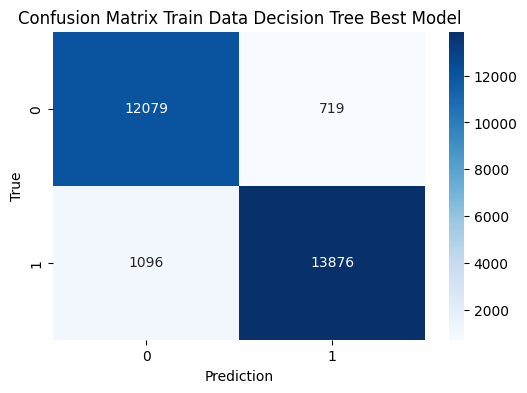

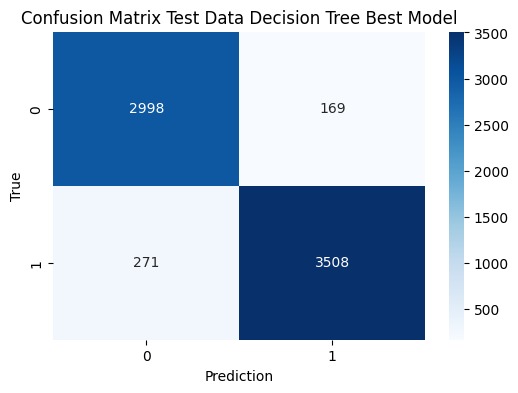

In [15]:
# show prediction scores
prediction_matrices(model = best_model, X_train= X_train, X_test= X_test, y_train=y_train, y_test= y_test, model_name= "Decision Tree Best Model")



The pruning of the decision tree was succesfull. The results for train and test data for all relevant scores are within a similar range.   
This means that there is no more overfitting.

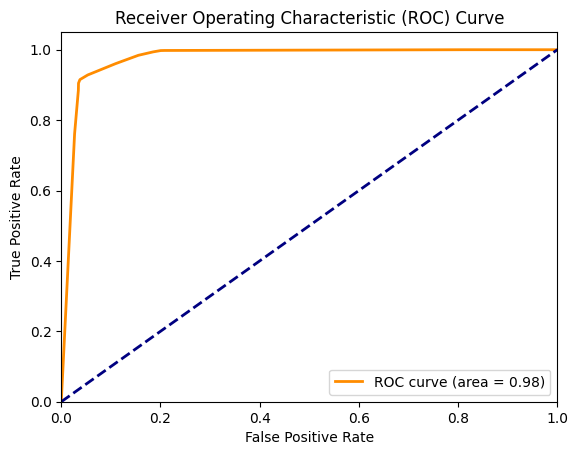

In [16]:
# ROC Curve
y_pred_roc = best_model.predict_proba(X_test)[:, 1] # Probability of positive class

fpr, tpr, thresholds = roc_curve(y_test, y_pred_roc)

# Calculate AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [17]:
# Scores
print("Scores for hyperparameter tuned decision tree")
print("________________________________")
print('F1-Score=%.3f' % (f1_score(y_test, y_pred_grid)))
print('Precision=%.3f, Recall=%.3f, Accuracy = %.3f' % (precision_score(y_test, y_pred_grid), recall_score(y_test, y_pred_grid), accuracy_score(y_test, y_pred_grid)))


Scores for hyperparameter tuned decision tree
________________________________
F1-Score=0.941
Precision=0.954, Recall=0.928, Accuracy = 0.937


**Note**
For model types like logistic regression, the idea of thresholds is to convert a probability into a discrete class based on a given threshold. However, decision trees already predict discrete classes ("hard class assignment") and do not use probabilities for that. Therefore, we cannot change thresholds in order to optimize our model for a specific use case.

## Distribution of Prediction Probabilities
Nonetheless, the concept of probabilities exist for decision trees in another form.
In decision trees, samples are sorted into different leaves based on optimized splitting criteria to achieve maximum homogeneity or ‘purity’. The predicted probability for a class in a leaf node is given by the proportion of samples of that class in the node. As a result, especially in deep trees, many samples may end up in ‘pure’ leafs where all samples belong to a single class (0 or 1).
As shown in "Distribution of prediction probabilities" (below), one can see that the vast majority of samples are sorted into pure leafs (0 or 1).

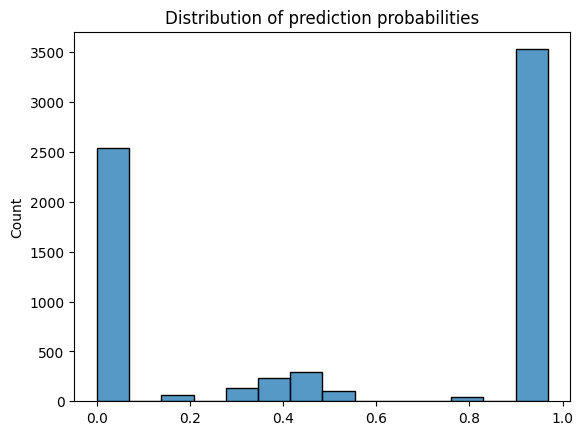

In [18]:
# get probabilities for predictions on X_test
y_probe = best_model.predict_proba(X_test)

# plot distribution of prediction probabilities
fig = sns.histplot(y_probe[:,1]) #get probabilities for churn_risk_score = 1
plt.title("Distribution of prediction probabilities")
plt.show(fig)


## Visualize Decision Tree

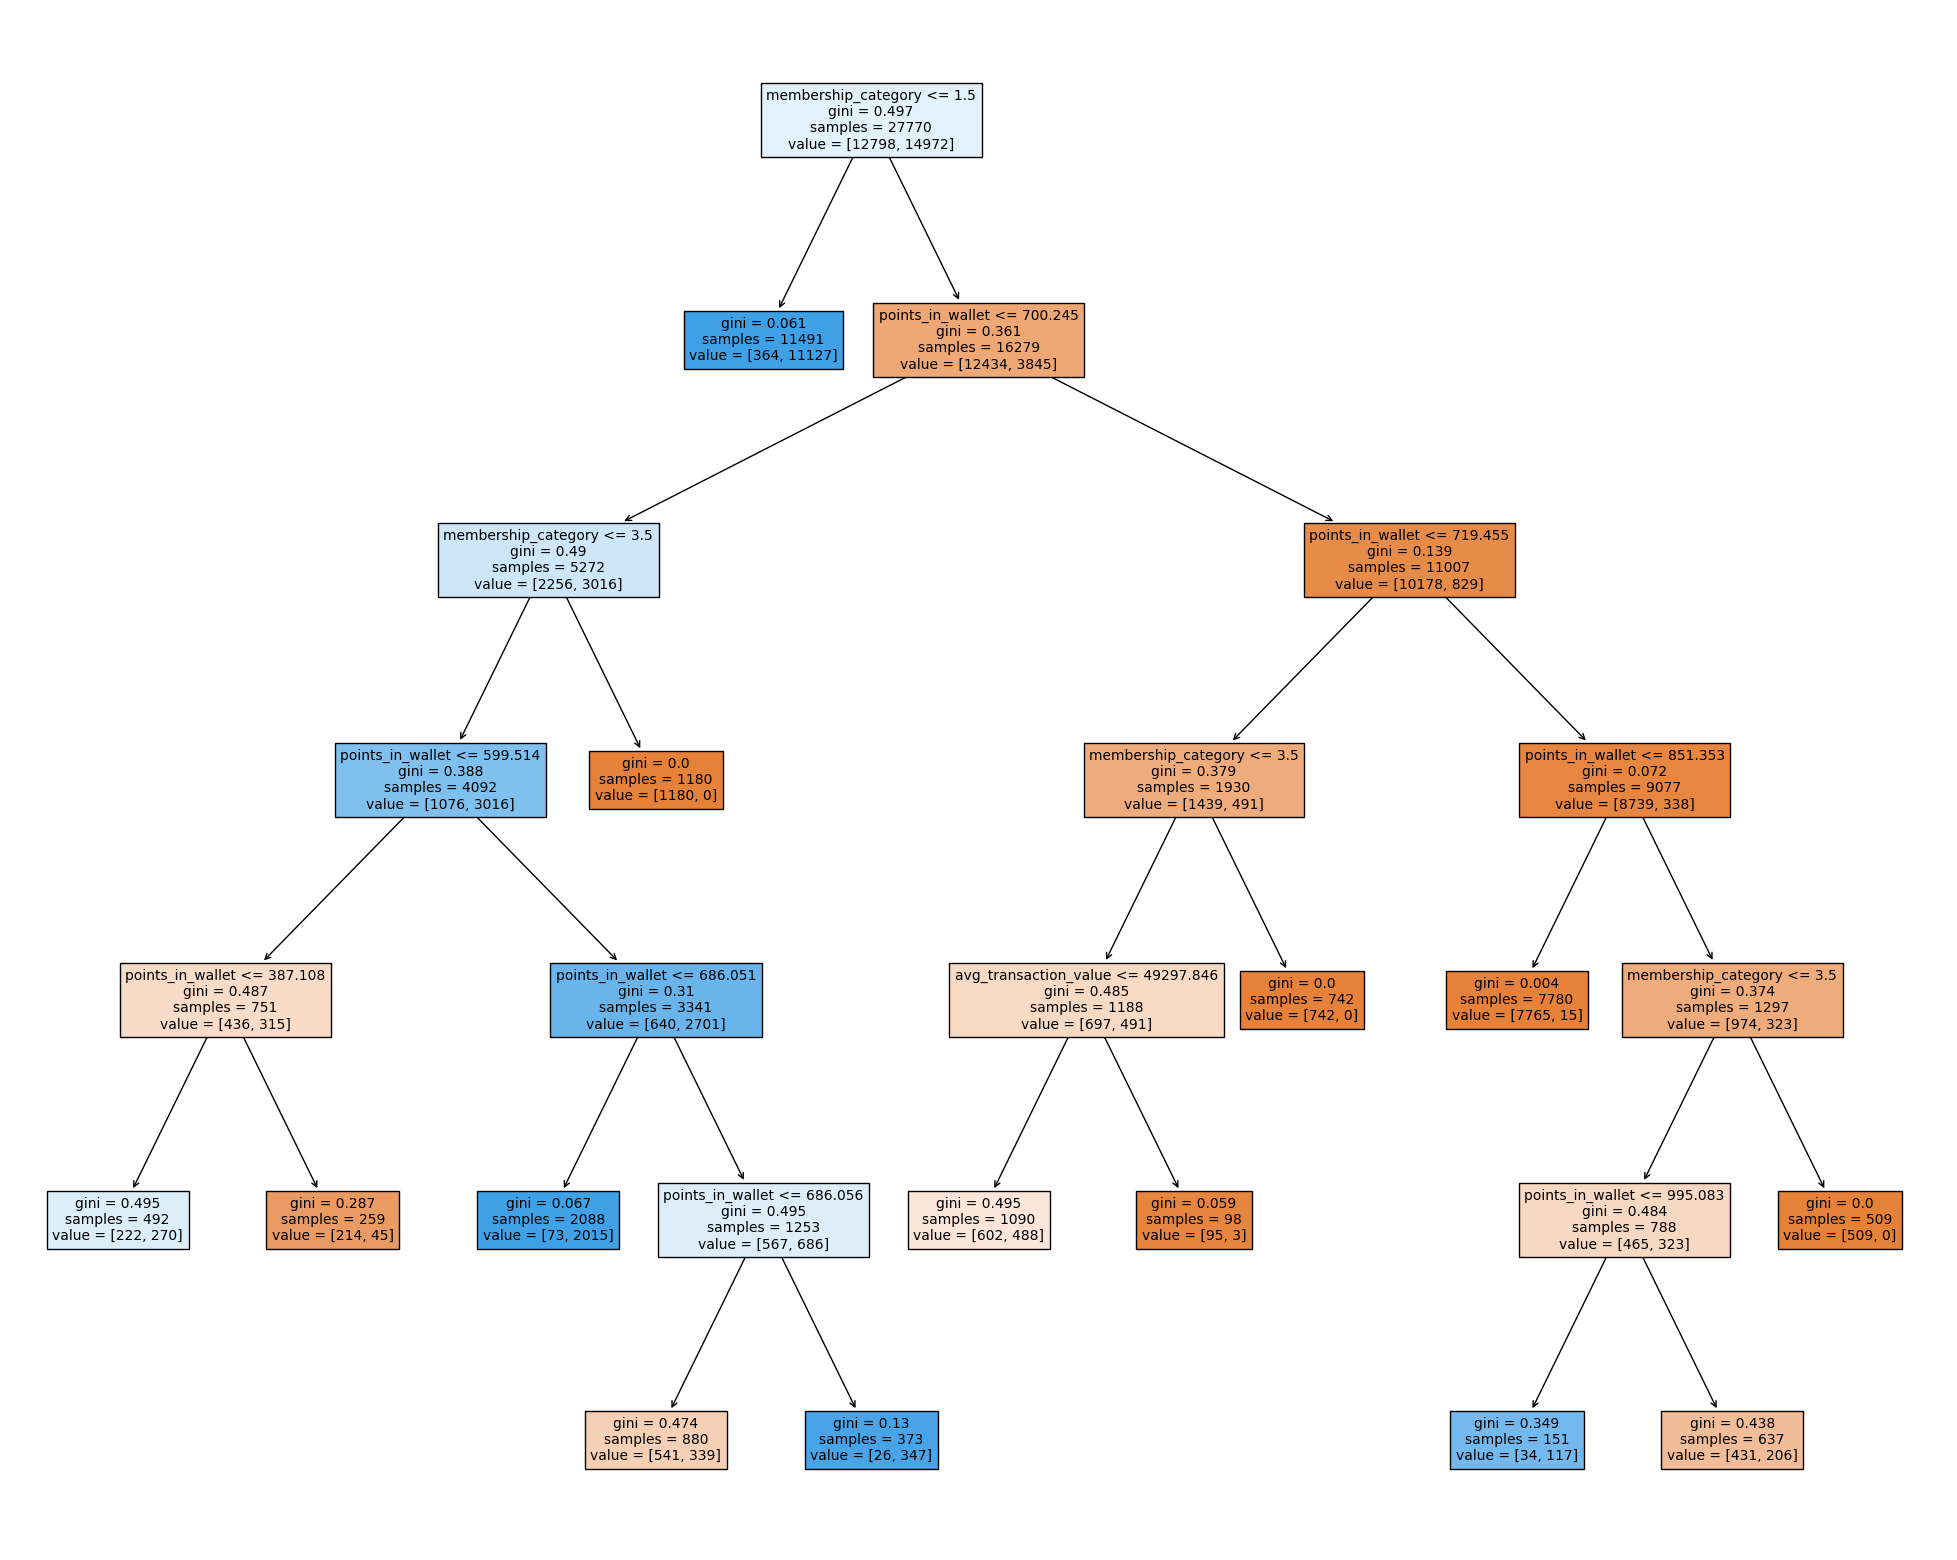

In [19]:
fig = plt.figure(figsize=(25,20))
dectree_plot = plot_tree(best_model,feature_names=features, filled=True,fontsize= 10)

The resulting in decision tree especially utilizes membership_category and points_in_wallet for its predictive power.

The first step is to predict members with a high quality membership class as unlikely to churn (< 1.5). For the rest, it mostly compares whether a member belongs to a membership class >= 4 or <= 3 (medium membership class) and possesses above or below a specific number of points_in_wallets.

## Feature Importance for one-hot encoded Features

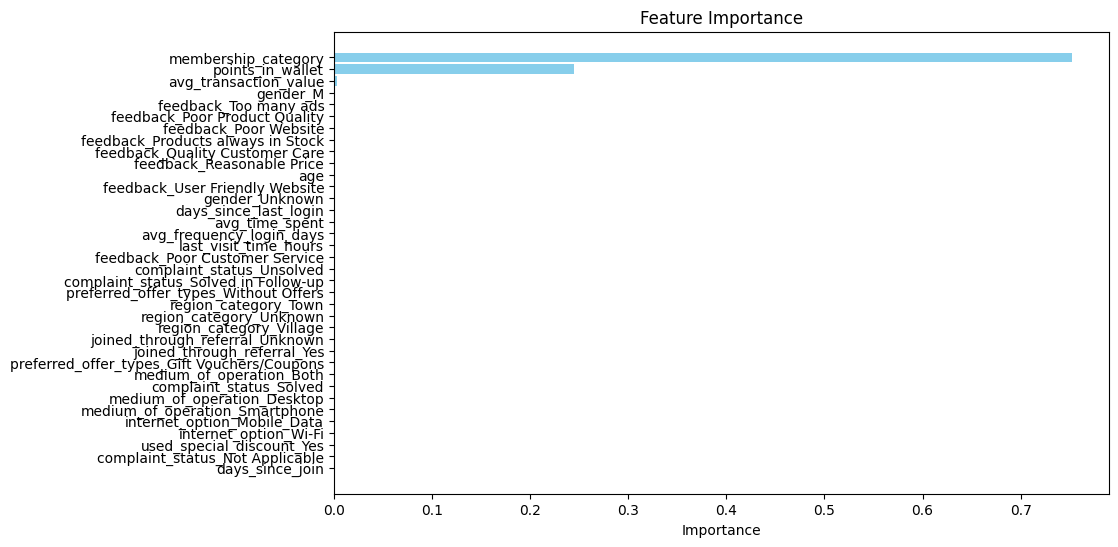

In [20]:
#feature importance

importances = best_model.feature_importances_
features = X_train.columns


# create data frame for handling importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# sort by importances
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# create Plot
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

With the hyperparameter tuned decision tree, we found that the prediction mainly depends on two features ('membership_category' and 'points_in_wallet') but also on avg_transaction_value. This analysis confirms our findings from the visualized decision tree.   
This finding is surprising because in the logistic regression model 'feedback' was the most important feature.

## Save Model

In [21]:
# Save model
with open('./model/model_dectree_grid.pkl', 'wb') as file:
    pickle.dump(best_model, file)

## Add predictions to dataframe for evaluation

In [22]:
# create a data set with the predicted values for evaluation of test-data:
df_test_eval = df_test.copy()
y_pred = best_model.predict(X_test)
df_test_eval['y_pred'] = y_pred

# create a data set with the predicted values for evaluation of  train-test:
df_train_eval = df_train.copy()
y_pred_train = best_model.predict(X_train)
df_train_eval['y_pred'] = y_pred_train

# check if subfolder exists:
if not os.path.exists('./data/eval'):
        os.makedirs('./data/eval')

# write the dataframes with prediction outcome for next notebook 
df_train_eval.to_pickle('./data/eval/df_train_eval_decision_tree.pkl')
df_test_eval.to_pickle('./data/eval/df_test_eval_decision_tree.pkl')

## Save metrics

In [23]:
# save metrics for pruned decision tree
save_metrics('dtree', 
            accuracy_score(y_test, y_pred_grid), 
            precision_score(y_test, y_pred_grid), 
            recall_score(y_test, y_pred_grid), 
            f1_score(y_test, y_pred_grid), 
            roc_auc,
            )

df loaded
Metrics for dtree saved successfully!


In [24]:
# Check df_metrics
df_metrics = pd.read_pickle('./data/df_metrics.pkl')
print(df_metrics)

                                   model  accuracy  precision    recall  \
logreg_youden              logreg_youden  0.883386   0.939331  0.839905   
logreg_max_F1              logreg_max_F1  0.872876   0.829390  0.964806   
logreg_st_threshold  logreg_st_threshold  0.855744   0.851252  0.890447   
dtree                              dtree  0.936654   0.954039  0.928288   

                           F1   ROC_AUC  
logreg_youden        0.886840  0.953799  
logreg_max_F1        0.891988  0.953799  
logreg_st_threshold  0.870409  0.953799  
dtree                0.940987  0.975058  
